#Downloading Dataset

In [1]:
!wget http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip

--2024-04-13 05:54:21--  http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip
Resolving weegee.vision.ucmerced.edu (weegee.vision.ucmerced.edu)... 169.236.184.65
Connecting to weegee.vision.ucmerced.edu (weegee.vision.ucmerced.edu)|169.236.184.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 332468434 (317M) [application/zip]
Saving to: ‘UCMerced_LandUse.zip’

UCMerced_LandUse.zi 100%[===================>] 317.07M   169KB/s    in 3m 41s  

2024-04-13 05:58:03 (1.43 MB/s) - ‘UCMerced_LandUse.zip’ saved [332468434/332468434]



In [2]:
!unzip /content/UCMerced_LandUse.zip

Archive:  /content/UCMerced_LandUse.zip
   creating: UCMerced_LandUse/Images/
   creating: UCMerced_LandUse/Images/agricultural/
  inflating: UCMerced_LandUse/Images/agricultural/agricultural00.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural01.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural02.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural03.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural04.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural05.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural06.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural07.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural08.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural09.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural10.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural11.tif  
  inflating: UCMerc

#Train Test Split

In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split

def split_data_into_dirs(source_directory, train_directory, test_directory, test_size=0.2, random_state=42):
    """
    Function to split data into train and test directories.
    """
    # Create train and test directories if they don't exist
    if not os.path.exists(train_directory):
        os.makedirs(train_directory)
    if not os.path.exists(test_directory):
        os.makedirs(test_directory)

    # Get subdirectories
    subdirectories = [d for d in os.listdir(source_directory) if os.path.isdir(os.path.join(source_directory, d))]

    # Perform train-test split for each subdirectory
    for subdir in subdirectories:
        subdir_path = os.path.join(source_directory, subdir)
        train_subdir = os.path.join(train_directory, subdir)
        test_subdir = os.path.join(test_directory, subdir)

        # Create train and test subdirectories
        os.makedirs(train_subdir, exist_ok=True)
        os.makedirs(test_subdir, exist_ok=True)

        # Get list of images in subdirectory
        images = [f for f in os.listdir(subdir_path) if f.endswith('.tif')]

        # Perform train-test split
        train_images, test_images = train_test_split(images, test_size=test_size, random_state=random_state)

        # Move images to train and test directories
        for image in train_images:
            shutil.copy(os.path.join(subdir_path, image), os.path.join(train_subdir, image))
        for image in test_images:
            shutil.copy(os.path.join(subdir_path, image), os.path.join(test_subdir, image))

# Set source directory containing subdirectories with TIFF images
source_directory = "/content/UCMerced_LandUse/Images/"

# Set target directories for training and testing data
train_directory = "/content/UCMerced_LandUse/train"
test_directory = "/content/UCMerced_LandUse/test"

# Perform train-test split and move images to respective directories
split_data_into_dirs(source_directory, train_directory, test_directory)

# Print confirmation message
print("Data has been split into training and testing directories.")


Data has been split into training and testing directories.


#Imports

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms, datasets
import os


#Dataloader

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder('/content/UCMerced_LandUse/train', transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)


#Defining Resnet50

In [6]:
model = torchvision.models.resnet50(pretrained=True)
num_classes = len(train_dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 168MB/s]


#Training (Skip This)

In [7]:


# Initialize variables for early stopping
best_loss = float('inf')
patience = 10  # Number ofa epochs to wait before early stopping
counter = 0

# Your training loop
num_epochs = 30
for epoch in range(num_epochs):
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Calculate average training loss for the epoch
    train_loss /= len(train_loader)

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}')

    # Check for early stopping based on training loss
    if train_loss < best_loss:
        best_loss = train_loss
        counter = 0
        # Save the model
        save_path = f'uc_merced_{epoch}_resnet50.pth'
        torch.save(model.state_dict(), save_path)
        print(f"Model saved to '{save_path}'")
    else:
        counter += 1
        if counter >= patience:
            print(f'Training loss did not decrease for {patience} epochs. Early stopping...')
            break

print("Training finished.")


Epoch [1/30], Training Loss: 1.6539
Model saved to 'uc_merced_0_resnet50.pth'
Epoch [2/30], Training Loss: 0.8892
Model saved to 'uc_merced_1_resnet50.pth'
Epoch [3/30], Training Loss: 0.6130
Model saved to 'uc_merced_2_resnet50.pth'
Epoch [4/30], Training Loss: 0.4658
Model saved to 'uc_merced_3_resnet50.pth'
Epoch [5/30], Training Loss: 0.4743
Epoch [6/30], Training Loss: 0.3501
Model saved to 'uc_merced_5_resnet50.pth'
Epoch [7/30], Training Loss: 0.3237
Model saved to 'uc_merced_6_resnet50.pth'
Epoch [8/30], Training Loss: 0.3176
Model saved to 'uc_merced_7_resnet50.pth'
Epoch [9/30], Training Loss: 0.2268
Model saved to 'uc_merced_8_resnet50.pth'
Epoch [10/30], Training Loss: 0.1839
Model saved to 'uc_merced_9_resnet50.pth'
Epoch [11/30], Training Loss: 0.1925
Epoch [12/30], Training Loss: 0.1575
Model saved to 'uc_merced_11_resnet50.pth'
Epoch [13/30], Training Loss: 0.1530
Model saved to 'uc_merced_12_resnet50.pth'
Epoch [14/30], Training Loss: 0.1238
Model saved to 'uc_merced_1

#Downloading PreTrained Weights

In [7]:
import gdown

url = 'https://drive.google.com/uc?id=1-33n-oVZuU7t0ZFGejWPtTBDgCPzejIX'
output_path = 'uc_merced_resnet50.pth'

gdown.download(url, output_path, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1-33n-oVZuU7t0ZFGejWPtTBDgCPzejIX
From (redirected): https://drive.google.com/uc?id=1-33n-oVZuU7t0ZFGejWPtTBDgCPzejIX&confirm=t&uuid=e6e9a10c-d430-4f9d-9666-e029efcf4214
To: /content/uc_merced_resnet50.pth
100%|██████████| 94.5M/94.5M [00:01<00:00, 72.5MB/s]


'uc_merced_resnet50.pth'

#Evaluation using PreTrained Weights

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Accuracy on the test set: 93.33%
Precision: 0.9374
Recall: 0.9333


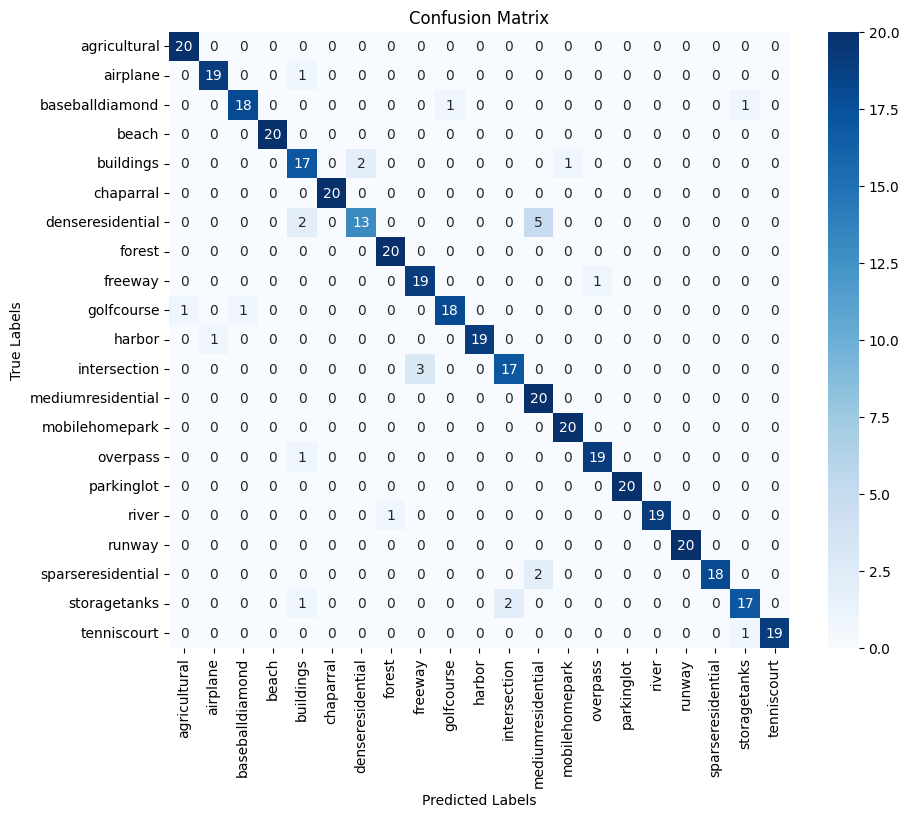

In [8]:


# Load the pre-trained ResNet50 model
model = torchvision.models.resnet50(pretrained=False)  # Load without pretrained weights
num_classes = 21
model.fc = nn.Linear(model.fc.in_features, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Load the trained weights
weights_path = '/content/uc_merced_resnet50.pth'  # Path to the saved weights
model.load_state_dict(torch.load(weights_path))

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the transformations for test data
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load the test dataset and create a data loader
test_dataset = datasets.ImageFolder('/content/UCMerced_LandUse/test', transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Evaluate the model on the test set
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')

# Print the evaluation metrics
print(f'Accuracy on the test set: {100 * accuracy:.2f}%')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

# Plot the confusion matrix
conf_mat = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


#Inference on Single Image

In [13]:
from PIL import Image

def predict_single_image(image_path):
    image = Image.open(image_path)
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
        class_idx = predicted.item()
        class_label = train_dataset.classes[class_idx]
        print(f'Predicted class: {class_label}')

# Provide the path to the single image
image_path = '/content/UCMerced_LandUse/test/airplane/airplane00.tif'
predict_single_image(image_path)


Predicted class: airplane
